# Model Errors RMSE

In this notebook we compare different versions of the Heston MC model, and calculate model errors vs closed form solution.
We do so for two different datasets, one with lower vol of vol, and one higher.

In [ ]:
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qablet_contracts.eq.vanilla import Option
from qablet_contracts.timetable import py_to_ts

from src.models.aes import HestonAESMC
from src.models.basic import HestonMCBasic
from src.models.better import HestonMCBetter
from src.models.closed import price_vanilla_call

## Create Dataset
Create the dataset, with MC params, discounts and fwds as required by the [Dataset API](https://qablet-academy.github.io/intro/dataset/)

In [ ]:
# Rate Curve
times = np.array([0.0, 5.0])
rates = np.array([0.1, 0.1])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

# Forward Curve
ticker = "EQ"
spot = 100.0
div_rate = 0.0
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

pricing_datetime = datetime(2023, 12, 31)
dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(pricing_datetime).value,
    "ASSETS": {"USD": discount_data, ticker: fwd_data},
    "MC": {
        "PATHS": 10_000,  # changed later
        "TIMESTEP": 1 / 1000,  # changed later
        "SEED": 1,
    },
    "HESTON": {
        "ASSET": ticker,
        # Heston parameters will be filled later.
    },
}

## Create Contract and models

Define a [Vanilla Option](https://qablet.github.io/qablet-contracts/examples/equity_vanilla/).

In [ ]:
strike = 100
timetable = Option(
    "USD", ticker, strike=strike, maturity=datetime(2024, 12, 31), is_call=True
).timetable()

### Create Models
We will use three models. The first two are defined in this repositary. The third one is from the qablet-basic package. 

In [ ]:
models = {
    "Basic": HestonMCBasic(),
    "AES": HestonAESMC(),
    "Better": HestonMCBetter(),  # Uses Log Euler for spot, antithetic paths, and milstein discretization for vol
}

# Mean Square Errors
Run simulation with different seeds, and calculate the MSE, for a given model, and dataset.

In [ ]:
def calc_mse(
    model,
    ref_price,
    dataset,
    timetable,
    iters=25,
):
    errors = []
    start_time = time.time()
    for seed in range(1, iters):
        dataset["MC"]["SEED"] = seed
        price, _ = model.price(timetable, dataset)
        errors.append(price - ref_price)

    elapsed_time = (time.time() - start_time) / iters
    rmse = np.sqrt(np.square(errors).mean())
    err = np.mean(errors)
    return err, rmse, elapsed_time

We will use two different datasets. The first one is same as used by [Nicholas Burgess](https://github.com/nburgessx/Papers/tree/main/HestonSimulation). The latter is used by Gatheral in his book `The Volatility Surface`. The first one has a higher vol of vol, and lower mean reversion. (Neither of them satisfies the Feller condition).

In [ ]:
all_params = {
    "High-VVol": {
        "INITIAL_VAR": 0.04,
        "LONG_VAR": 0.04,
        "VOL_OF_VAR": 1.0,
        "MEANREV": 0.5,
        "CORRELATION": -0.9,
    },
    "Low-VVol": {
        "INITIAL_VAR": 0.0174,
        "LONG_VAR": 0.0354,
        "VOL_OF_VAR": 0.3877,
        "MEANREV": 1.3253,
        "CORRELATION": -0.7165,
    },
}


Running: High-VVol (Paths = 2500) T = 0.1, T = 0.01, T = 0.004, 
Running: Low-VVol (Paths = 2500) T = 0.1, T = 0.01, T = 0.004, 
Running: High-VVol (Paths = 100000) T = 0.1, T = 0.01, T = 0.004, 
Running: Low-VVol (Paths = 100000) T = 0.1, T = 0.01, T = 0.004, 

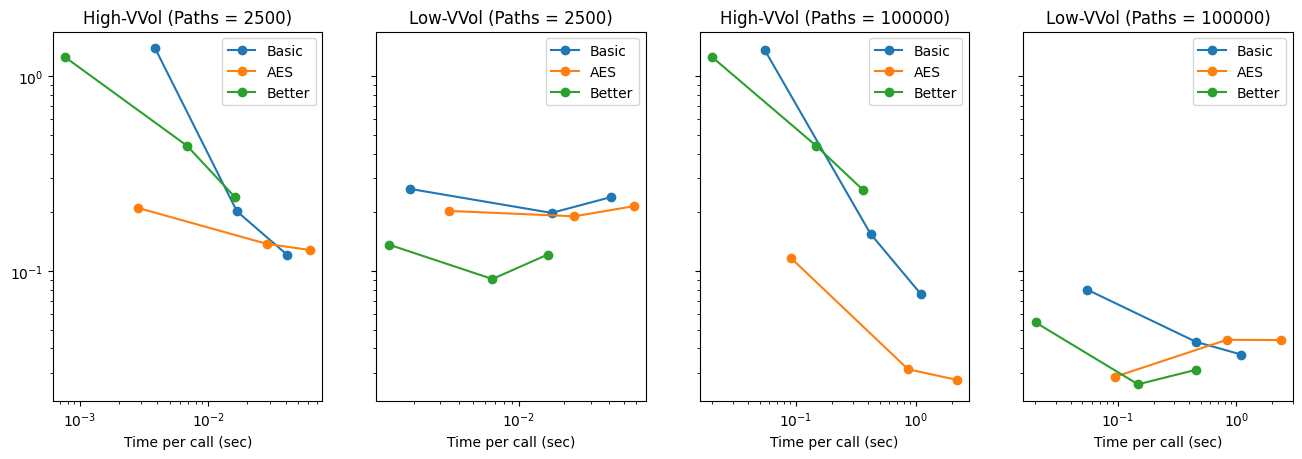

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figwidth(16)

for i, paths in enumerate([2_500, 100_000]):
    dataset["MC"]["PATHS"] = paths

    for j, (param_name, params) in enumerate(all_params.items()):
        print(f"\nRunning: {param_name} (Paths = {paths})", end=" ")
        dataset["HESTON"].update(params)

        # Closed form price
        ref_price, _ = price_vanilla_call(
            strike,
            1.00,
            ticker,
            dataset,
        )

        df = pd.DataFrame(columns=["Model", "RMSE", "Exec Time"])
        # We are running for 3 different timesteps,
        # However, instead of plotting RMSE vs timestep, we will plot RMSE vs exec time.
        for timestep in [1 / 10, 1 / 100, 1 / 250]:
            print(f"T = {timestep}", end=", ")
            dataset["MC"]["TIMESTEP"] = timestep
            for model_name, model in models.items():
                err, rmse, elapsed_time = calc_mse(
                    model=model,
                    ref_price=ref_price,
                    dataset=dataset,
                    timetable=timetable,
                )
                df.loc[len(df)] = [model_name, rmse, elapsed_time]

        ax = axes[i * 2 + j]
        for m, model_name in enumerate(models):
            subdf = df[df["Model"] == model_name]
            ax.loglog(
                subdf["Exec Time"],
                subdf["RMSE"],
                label=model_name,
                marker="o",
            )
        ax.legend()
        ax.set_xlabel("Time per call (sec)")
        ax.set_title(f"{param_name} (Paths = {paths})")